In [2]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import timeit
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder

In [3]:
graphml_file = "Airtel.graphml"  # Replace with your file
G = nx.read_graphml(graphml_file)
G = G.to_undirected()

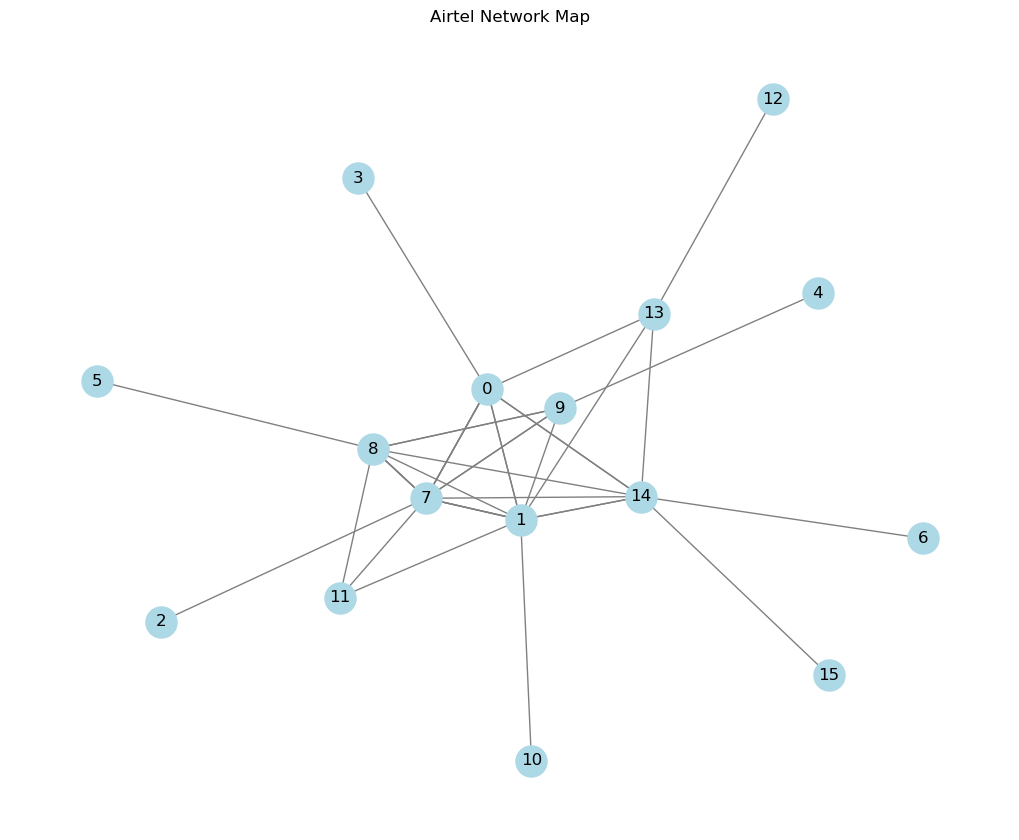

In [4]:
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500)
plt.title("Airtel Network Map")
plt.show()

In [5]:
# Compute geographical distances between connected nodes
for u, v, data in G.edges(data=True):
    node_u = G.nodes[u]
    node_v = G.nodes[v]
    
    # Get coordinates (handle missing values)
    coords_u = (node_u.get('Latitude', 0), node_u.get('Longitude', 0))
    coords_v = (node_v.get('Latitude', 0), node_v.get('Longitude', 0))
    
    # Calculate geodesic distance in kilometers
    distance = geodesic(coords_u, coords_v).km
    data['distance'] = distance
    print(distance)

14433.880849560373
14433.880849560373
12584.918032604863
11672.115007209588
14135.810389418217
14135.810389418217
3944.4110951634307
3944.4110951634307
3944.4110951634307
13488.533266420476
13488.533266420476
13488.533266420476
8217.238744141236
1030.322709289313
7110.07391084831
7802.974255107388
3725.958760382604
2907.602753284339
2907.602753284339
8667.450755395048
8213.971768056132
5708.673565674014
11560.132198188205
5585.225518295435
5585.225518295435
5585.225518295435
12561.341268361408
12561.341268361408
6323.104998539124
15347.459563867087
7202.516067426183
7202.516067426183
1002.692055436303
10859.736589587055
12494.211838289139
2577.0883259741386
11560.132198188205


In [6]:
# Create a set to store unique LinkLabel values
link_labels = set()

# Iterate through the edges and collect LinkLabel values
for u, v, data in G.edges(data=True):
    link_label = data.get('LinkLabel', None)
    if link_label:
        link_labels.add(link_label)

# Convert the set to a list to view the unique values
unique_link_labels = list(link_labels)
print(unique_link_labels)

['Medium-Low Bandwidth', 'Low Bandwidth', 'Medium-High Bandwidth', 'High Bandwidth']


In [7]:
label_mapping = {
    'High Bandwidth': 'High',
    'Medium-High Bandwidth': 'Medium',
    'Low Bandwidth': 'Low',
    'Medium-Low Bandwidth': 'Low'
}

# Iterate through the edges and update the LinkLabel values
for u, v, data in G.edges(data=True):
    link_label = data.get('LinkLabel', None)
    if link_label:
        simplified_label = label_mapping.get(link_label, link_label)  # Simplify using the mapping
        data['LinkLabel'] = simplified_label  # Update the LinkLabel attribute

In [8]:
# Extract the LinkLabel values from the edges of the graph
# Check for the 'LinkLabel' attribute with .get() to avoid KeyError
link_labels = [data.get('LinkLabel', 'Low') for u, v, data in G.edges(data=True)]
print(link_labels)

['Medium', 'High', 'Low', 'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Low', 'High', 'High', 'Low', 'Low', 'Low', 'High', 'High', 'Low', 'High', 'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'Low']


In [53]:
# Extract the LinkLabel values along with the nodes
for u, v, data in G.edges(data=True):
    link_label = data.get('LinkLabel', 'Low')  # Default to 'Low' if missing
    print(f"Edge ({u} → {v}): Bandwidth = {link_label}")


Edge (0 → 1): Bandwidth = Medium
Edge (0 → 1): Bandwidth = High
Edge (0 → 3): Bandwidth = Low
Edge (0 → 13): Bandwidth = Medium
Edge (0 → 14): Bandwidth = Medium
Edge (0 → 14): Bandwidth = Medium
Edge (0 → 7): Bandwidth = Low
Edge (0 → 7): Bandwidth = Low
Edge (0 → 7): Bandwidth = Low
Edge (1 → 7): Bandwidth = High
Edge (1 → 7): Bandwidth = High
Edge (1 → 7): Bandwidth = Low
Edge (1 → 8): Bandwidth = Low
Edge (1 → 9): Bandwidth = Low
Edge (1 → 10): Bandwidth = High
Edge (1 → 11): Bandwidth = High
Edge (1 → 13): Bandwidth = Low
Edge (1 → 14): Bandwidth = High
Edge (1 → 14): Bandwidth = High
Edge (2 → 7): Bandwidth = Low
Edge (4 → 9): Bandwidth = Low
Edge (5 → 8): Bandwidth = Low
Edge (6 → 14): Bandwidth = Low
Edge (7 → 8): Bandwidth = Low
Edge (7 → 8): Bandwidth = Low
Edge (7 → 8): Bandwidth = Low
Edge (7 → 9): Bandwidth = Low
Edge (7 → 9): Bandwidth = Low
Edge (7 → 11): Bandwidth = High
Edge (7 → 14): Bandwidth = Low
Edge (8 → 9): Bandwidth = Low
Edge (8 → 9): Bandwidth = Low
Edge (8 →

In [9]:
link_labels_reshaped = np.array(link_labels).reshape(-1, 1)

# Initialize the OneHotEncoder (no need for sparse=False)
encoder = OneHotEncoder()

# Fit and transform the link_labels into one-hot encoding
one_hot_encoded = encoder.fit_transform(link_labels_reshaped).toarray()  # Convert sparse matrix to array

# Check the one-hot encoded result
print(one_hot_encoded)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [10]:
# Add the one-hot encoded vector to each edge in the graph
for idx, (u, v, data) in enumerate(G.edges(data=True)):
    # Assuming one_hot_encoded[idx] is the one-hot vector for the edge (u, v)
    data['OneHotLinkLabel'] = one_hot_encoded[idx]

# Check the edge data to ensure the one-hot encoding is added
print(G.edges(data=True))

[('0', '1', {'LinkLabel': 'Medium', 'key': 0, 'distance': 14433.880849560373, 'OneHotLinkLabel': array([0., 0., 1.])}), ('0', '1', {'LinkLabel': 'High', 'key': 1, 'distance': 14433.880849560373, 'OneHotLinkLabel': array([1., 0., 0.])}), ('0', '3', {'LinkLabel': 'Low', 'key': 0, 'distance': 12584.918032604863, 'OneHotLinkLabel': array([0., 1., 0.])}), ('0', '13', {'LinkLabel': 'Medium', 'key': 0, 'distance': 11672.115007209588, 'OneHotLinkLabel': array([0., 0., 1.])}), ('0', '14', {'LinkLabel': 'Medium', 'key': 0, 'distance': 14135.810389418217, 'OneHotLinkLabel': array([0., 0., 1.])}), ('0', '14', {'LinkLabel': 'Medium', 'key': 1, 'distance': 14135.810389418217, 'OneHotLinkLabel': array([0., 0., 1.])}), ('0', '7', {'LinkLabel': 'Low', 'key': 0, 'distance': 3944.4110951634307, 'OneHotLinkLabel': array([0., 1., 0.])}), ('0', '7', {'LinkLabel': 'Low', 'key': 1, 'distance': 3944.4110951634307, 'OneHotLinkLabel': array([0., 1., 0.])}), ('0', '7', {'LinkLabel': 'Low', 'key': 2, 'distance': 3

In [11]:
# Combine edge features: bandwidth encoding + normalized distance
edge_features = []
for u, v, data in G.edges(data=True):
    bandwidth_encoding = data['OneHotLinkLabel']
    distance = data['distance']
    edge_features.append(np.concatenate([bandwidth_encoding, [distance]]))

# in the below, convert edge_features with np.array(edge_features), cause of that + stuff, its still showing + tho
edge_features = np.stack(edge_features)

In [12]:
print(edge_features)

[[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.44338808e+04]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 1.44338808e+04]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.25849180e+04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.16721150e+04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.41358104e+04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.41358104e+04]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 3.94441110e+03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 3.94441110e+03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 3.94441110e+03]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 1.34885333e+04]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 1.34885333e+04]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.34885333e+04]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 8.21723874e+03]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.03032271e+03]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 7.11007391e+03]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 7.802974

In [13]:
# --- Graph Neural Network Architecture ---
class PathOptimizerGCN(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super().__init__()
        # First convolution with edge features
        self.conv1 = GCNConv(node_dim, hidden_dim)
        # Edge score predictor
        self.edge_scorer = nn.Sequential(
            nn.Linear(2*hidden_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # Node feature propagation
        x = F.relu(self.conv1(x, edge_index))
    
        # Create edge representations
        src, dst = edge_index  # src and dst are tensors of shape [num_edges]
    
        # Gather node features for source and destination nodes
        src_features = x[src]  # Shape: [num_edges, node_feature_dim]
        dst_features = x[dst]  # Shape: [num_edges, node_feature_dim]
    
        # Ensure edge_attr is 2D
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(1)  # Shape: [num_edges, 1]
    
        # Concatenate node features and edge features
        edge_repr = torch.cat([src_features, dst_features, edge_attr], dim=1)  # Shape: [num_edges, 2*node_feature_dim + edge_feature_dim]
    
        # Predict edge scores (higher = better)
        edge_scores = torch.sigmoid(self.edge_scorer(edge_repr))
        return edge_scores.squeeze()

In [14]:
# --- Training Setup ---
# Convert to PyG Data

node_features = []
for _, data in G.nodes(data=True):
    if 'Latitude' in data and 'Longitude' in data and 'Internal' in data:
        node_features.append([data['Latitude'], data['Longitude'], data['Internal']])
    else:
        # Assign 0 for missing Latitude and Longitude, and retain the Internal value
        node_features.append([0, 0, data.get('Internal', 0)])  # Default Internal to 0 if missing
node_features = np.array(node_features)

node_features = torch.tensor(node_features, dtype=torch.float)

node_mapping = {node: idx for idx, node in enumerate(G.nodes())}
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v, _ in G.edges]).t().contiguous()
reverse_edges = edge_index[[1, 0]]  # Swap source and target
edge_index = torch.cat([edge_index, reverse_edges], dim=1)  # Shape: [2, 2*num_edges]

# Edge attributes with both directions
edge_attr = torch.tensor(edge_features, dtype=torch.float)
edge_attr = torch.cat([edge_attr, edge_attr], dim=0)  # Shape: [2*num_edges, edge_feature_dim]

data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

# Initialize model
model = PathOptimizerGCN(node_dim=3, edge_dim=4, hidden_dim=64)  # 3 node features, 4 edge features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
# --- Training Loop ---
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    # Generate edge scores
    edge_scores = model(data)
    
    # Create target scores: bandwidth priority (70%) + distance priority (30%)
    bandwidth_weights = data.edge_attr[:, :3] @ torch.tensor([1.0, 0.7, 0.3])  # [High, Medium, Low]
    distance_weights = 1 / (1 + data.edge_attr[:, 3])  # Inverse distance
    target_scores = 0.7 * bandwidth_weights + 0.3 * distance_weights
    
    # Ensure target_scores is 1D
    if target_scores.dim() > 1:
        target_scores = target_scores.squeeze()
    
    # Regression loss
    loss = F.mse_loss(edge_scores, target_scores)
    
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.2798
Epoch 2, Loss: 0.2580
Epoch 3, Loss: 0.2580
Epoch 4, Loss: 0.2580
Epoch 5, Loss: 0.2580
Epoch 6, Loss: 0.2580
Epoch 7, Loss: 0.2580
Epoch 8, Loss: 0.2580
Epoch 9, Loss: 0.2580
Epoch 10, Loss: 0.2580
Epoch 11, Loss: 0.2580
Epoch 12, Loss: 0.2580
Epoch 13, Loss: 0.2580
Epoch 14, Loss: 0.2580
Epoch 15, Loss: 0.2580
Epoch 16, Loss: 0.2580
Epoch 17, Loss: 0.2580
Epoch 18, Loss: 0.2580
Epoch 19, Loss: 0.2580
Epoch 20, Loss: 0.2580
Epoch 21, Loss: 0.2580
Epoch 22, Loss: 0.2580
Epoch 23, Loss: 0.2580
Epoch 24, Loss: 0.2580
Epoch 25, Loss: 0.2580
Epoch 26, Loss: 0.2580
Epoch 27, Loss: 0.2580
Epoch 28, Loss: 0.2580
Epoch 29, Loss: 0.2580
Epoch 30, Loss: 0.2580
Epoch 31, Loss: 0.2580
Epoch 32, Loss: 0.2580
Epoch 33, Loss: 0.2580
Epoch 34, Loss: 0.2580
Epoch 35, Loss: 0.2580
Epoch 36, Loss: 0.2580
Epoch 37, Loss: 0.2580
Epoch 38, Loss: 0.2580
Epoch 39, Loss: 0.2580
Epoch 40, Loss: 0.2580
Epoch 41, Loss: 0.2580
Epoch 42, Loss: 0.2580
Epoch 43, Loss: 0.2580
Epoch 44, Loss: 0.25

In [16]:
def find_redundant_paths(graph, edge_scores, source, target, k=3):
    """Find primary path and backup paths using edge scores"""
    # Create networkx graph with edge scores
    scored_graph = nx.Graph()
    
    for (u, v), score in zip(graph.edges(), edge_scores.detach().numpy()):
        scored_graph.add_edge(u, v, weight=1-score)  # Lower weight = better path
        
    # Find k-shortest paths based on scores
    paths = list(nx.shortest_simple_paths(scored_graph, source, target, weight='weight'))
    
    # Return primary and backup paths
    return paths[:k]

# Example usage with trained model
model.eval()
with torch.no_grad():
    edge_scores = model(data)


In [17]:
def print_country_paths(graph, paths):
    country_paths = []
    for path in paths:
        country_sequence = []
        for node in path:
            # Get country from node attributes
            country = graph.nodes[node].get('Country', 'Unknown Country Node')
            country_sequence.append(country)
        country_paths.append(" -> ".join(country_sequence))
    
    for i, path in enumerate(country_paths):
        print(f"Path {i+1}: {path}")

In [50]:
source = random.choice(list(G.nodes()))
target = random.choice(list(G.nodes()))
# source = '3'
# target = '4'

In [ ]:
## Get all paths
paths = list(nx.all_simple_paths(G, source=source, target=target))
print(paths)

In [20]:
max_degree_node = max(G.degree(), key=lambda x: x[1])[0]
failed_node = max_degree_node
if failed_node in [source, target]:
    print(f"The failed node is Node {failed_node}, the source node is {source} and the target node is {target}")
    print("The failed node cannot be same as the source/target node, please select another node")

In [51]:
print(failed_node, source, target) 

7 1 2


In [52]:
## WITHOUT Removing the critical node
# the try statement is if there are no paths at all, or there is only the Primary path
redundant_paths = find_redundant_paths(G, edge_scores, source, target, k=3)
try:
    print("Primary Path:", redundant_paths[0])
    print("Backup Path 1:", redundant_paths[1])
    print("Backup Path 2:", redundant_paths[2])
    print("\nThe actual countries for each Node:")
    print_country_paths(G, redundant_paths)
except:
    print(f"No other path exists from {source} to {target}")

Primary Path: ['1', '7', '2']
Backup Path 1: ['1', '0', '7', '2']
Backup Path 2: ['1', '8', '7', '2']

The actual countries for each Node:
Path 1: India -> United States -> Unknown Country Node
Path 2: India -> United States -> United States -> Unknown Country Node
Path 3: India -> United Kingdom -> United States -> Unknown Country Node


In [23]:
print(edge_scores)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


In [24]:
#### Print the degree for each node
print("Node Degrees:")
for node, degree in G.degree():
    print(f"{node}: {degree}")

Node Degrees:
0: 9
1: 12
2: 1
3: 1
4: 1
5: 1
6: 1
7: 14
8: 9
9: 6
10: 1
11: 3
12: 1
13: 4
14: 9
15: 1


In [25]:
def check_fault_tolerance(graph, source, target, failed_node):
    # Remove the node
    G_copy = graph.copy()
    G_copy.remove_node(failed_node)
    
    try:
        #shortest_path =nx.shortest_path(G_copy, source=source, target=target)
        redundant_paths = find_redundant_paths(G_copy, edge_scores, source, target, k=3)
        print(f"The Backup paths from {source} to {target} after failure of {failed_node}:")
        print("Primary Path:", redundant_paths[0])
        print("Backup Path 1:", redundant_paths[1])
        print("Backup Path 2:", redundant_paths[2])
        print_country_paths(G_copy, redundant_paths)
    except nx.NetworkXNoPath:
        print(f"No path exists from Node {source} to {target} after failure of {failed_node}.")
    except:
        print(f"No other path exists from {source} to {target}")

In [26]:
check_fault_tolerance(G, source, target, failed_node)

The Backup paths from 4 to 3 after failure of 7:
Primary Path: ['4', '9', '1', '0', '3']
Backup Path 1: ['4', '9', '8', '1', '0', '3']
Backup Path 2: ['4', '9', '1', '13', '0', '3']
Path 1: Unknown Country Node -> India -> India -> United States -> Unknown Country Node
Path 2: Unknown Country Node -> India -> United Kingdom -> India -> United States -> Unknown Country Node
Path 3: Unknown Country Node -> India -> India -> Hong Kong -> United States -> Unknown Country Node


In [27]:
shortest_path =nx.shortest_path(G, source=source, target=target)
print(shortest_path)

['4', '9', '1', '0', '3']


In [28]:
def calculate_reliability_ratio(graph, model, data, num_requests=100):
    successful_requests = 0
    
    for _ in range(num_requests):
        nodes = list(graph.nodes())
        source, target = random.sample(nodes, 2)
        failed_node = random.choice(nodes)

        # Ensure failed_node is not source, target, and does not disconnect them
        while failed_node in [source, target] or not nx.has_path(graph, source, target):
            failed_node = random.choice(nodes)

        # Create a copy of the graph and remove the failed node
        G_copy = graph.copy()
        G_copy.remove_node(failed_node)

        # Ensure target is still in the graph and reachable
        if target not in G_copy or not nx.has_path(G_copy, source, target):
            continue  # Skip this iteration if target is unreachable

        # Use the model to find redundant paths
        model.eval()
        with torch.no_grad():
            edge_scores = model(data)  # Get edge scores from the model
        
        redundant_paths = find_redundant_paths(G_copy, edge_scores, source, target, k=3)

        # Check if any of the paths are still valid in the modified graph
        path_found = any(nx.is_path(G_copy, path) for path in redundant_paths)

        if path_found:
            successful_requests += 1  # Path found

    reliability_ratio = successful_requests / num_requests
    return reliability_ratio


In [29]:
reliability = calculate_reliability_ratio(G, model, data, num_requests=100)
print(f"Network Reliability: {reliability * 100:.2f}%")

Network Reliability: 88.00%


In [30]:
print(G.nodes(data=True))

[('0', {'Internal': 1, 'Latitude': 34.05223, 'Country': 'United States', 'id': 0, 'Longitude': -118.24368, 'label': 'Los Angeles'}), ('1', {'Internal': 1, 'Latitude': 13.08784, 'Country': 'India', 'id': 1, 'Longitude': 80.27847, 'label': 'Chennai'}), ('2', {'Internal': 0, 'id': 2, 'label': 'NYIX'}), ('3', {'Internal': 0, 'id': 3, 'label': 'LAIX'}), ('4', {'Internal': 0, 'id': 4, 'label': 'NiXI'}), ('5', {'Internal': 0, 'id': 5, 'label': 'LINX'}), ('6', {'Internal': 0, 'id': 6, 'label': 'EQUINOX IX'}), ('7', {'Internal': 1, 'Latitude': 40.71427, 'Country': 'United States', 'id': 7, 'Longitude': -74.00597, 'label': 'New York'}), ('8', {'Internal': 1, 'Latitude': 51.50853, 'Country': 'United Kingdom', 'id': 8, 'Longitude': -0.12574, 'label': 'London'}), ('9', {'Internal': 1, 'Latitude': 19.01441, 'Country': 'India', 'id': 9, 'Longitude': 72.84794, 'label': 'Mumbai'}), ('10', {'Internal': 1, 'Latitude': 38.11582, 'Country': 'Italy', 'id': 10, 'Longitude': 13.35976, 'label': 'Palermo'}), ('

In [38]:
model_path = "gcn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to gcn_model.pth


In [36]:
torch.save(model, "gcn_model_full.pth")

In [37]:
# # Load pre-trained model with full structure
# model = torch.load("gcn_model_full.pth", weights_only=False)
# model.eval()